In [1]:
import glob
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata

In [2]:
import latexify
latexify.latexify()

In [3]:
def interpolate_missing_pixels(
        image: np.ndarray,
        mask: np.ndarray,
        method: str = 'nearest',
        fill_value: int = 0
):
    """
    :param image: a 2D image
    :param mask: a 2D boolean image, True indicates missing values
    :param method: interpolation method, one of
        'nearest', 'linear', 'cubic'.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image

In [4]:
data = [pickle.load(open(file, 'rb')) for file in glob.glob('benchmark_data/*.p')]

In [5]:
runtime_by_hoizon = {}
for entry in data:
    if entry['horizon'] not in runtime_by_hoizon:
        runtime_by_hoizon[entry['horizon']] = [[],[],[], [], []]
    
    runtime_by_hoizon[entry['horizon']][0].append(entry['hidden-dimensions'])
    runtime_by_hoizon[entry['horizon']][1].append(entry['hidden_layers'])
    runtime_by_hoizon[entry['horizon']][2].append(entry['find_max_abs_diff']['Runtime'])
    runtime_by_hoizon[entry['horizon']][3].append(entry['verify_stability_sufficient']['Runtime'])
    runtime_by_hoizon[entry['horizon']][4].append(entry['verify_stability_direct']['Runtime'])

for key in runtime_by_hoizon.keys():
    runtime_by_hoizon[key] = np.array(runtime_by_hoizon[key])

Horizon: 20


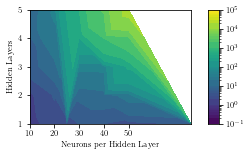

Horizon: 5


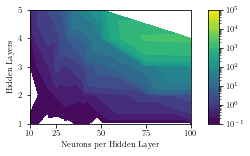

Horizon: 10


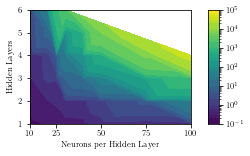

Horizon: 15


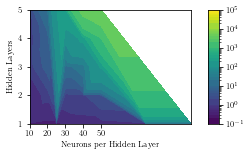

In [6]:
# https://stackoverflow.com/questions/18191867/matplotlib-contour-plot-proportional-colorbar-levels-in-logarithmic-scale

for horizon, values in runtime_by_hoizon.items():
    print(f'Horizon: {horizon}')
    plt.figure()
    gs = gridspec.GridSpec(1, 2,width_ratios=[15,1])
    ax1 = plt.subplot(gs[0])
    lvls = np.logspace(-1, 5, 20)
    ax1.tricontourf(values[0], values[1]+1, values[2], norm=LogNorm(), levels=lvls)
    ax1.set_xlabel('Neurons per Hidden Layer')
    if horizon <= 10:
        ax1.set_xticks([10, 25, 50, 75, 100])
    else:
        ax1.set_xticks([10, 20, 30, 40, 50])
    ax1.set_ylabel('Hidden Layers')
    if horizon == 10:
        ax1.set_yticks([1, 2, 3, 4, 5, 6])
    else:
        ax1.set_yticks([1, 2, 3, 4, 5])
    ax2 = plt.subplot(gs[1])
    levls = np.array([])
    #levls = np.concatenate((levls[:-1],np.linspace(1e-2,1e-1,10)))
    levls = np.concatenate((levls[:-1],np.linspace(1e-1,1e0,10)))
    levls = np.concatenate((levls[:-1],np.linspace(1e0,1e1,10)))
    levls = np.concatenate((levls[:-1],np.linspace(1e1,1e2,10)))
    levls = np.concatenate((levls[:-1],np.linspace(1e2,1e3,10)))
    levls = np.concatenate((levls[:-1],np.linspace(1e3,1e4,10)))
    levls = np.concatenate((levls[:-1],np.linspace(1e4,1e5,10)))
    XC = [np.zeros(len(levls)), np.ones(len(levls))]
    YC = [levls, levls]
    CM = ax2.contourf(XC,YC,YC, levels=levls, norm = LogNorm())
    ax2.set_yscale('log')  
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    plt.savefig(f'figures/comp_times_abs_error_{horizon}.pdf', bbox_inches='tight', pad_inches=0.03)
    plt.show()

Horizon: 20


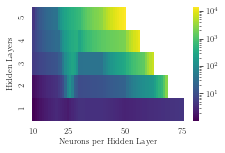

Horizon: 5


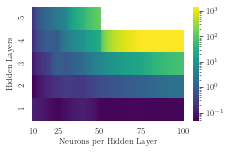

Horizon: 10


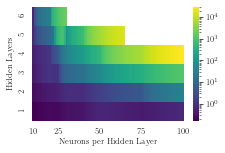

Horizon: 15


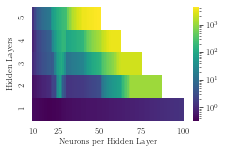

In [7]:
for horizon, values in runtime_by_hoizon.items():
    print(f'Horizon: {horizon}')
    x_axis_labels = np.arange(np.min(values[0]), np.max(values[0]) + 1)
    y_axis_labels = np.arange(np.min(values[1]+1), np.max(values[1]+1) + 1)
    data = np.zeros((len(x_axis_labels), len(y_axis_labels)))
    for i in range(values.shape[1]):
        data[int(values[0, i] - np.min(values[0])), int(values[1, i] - np.min(values[1]))] = values[2, i]
        
    x_axis_labels = [(int(x) if x in [10, 25, 50, 75, 100] else None) for x in x_axis_labels]
    y_axis_labels = [(int(x) if x in [1, 2, 3, 4, 5, 6] else None) for x in y_axis_labels]
    mask = np.zeros_like(data, dtype=bool)
    mask[data == 0] = True
    
    data = interpolate_missing_pixels(data, mask, 'linear')
    
    with sns.axes_style('white'):
        sns.heatmap(np.flip(data, axis=1).T, xticklabels=x_axis_labels, yticklabels=np.flip(y_axis_labels), rasterized=True, cmap='viridis', norm=LogNorm())
    plt.xlabel('Neurons per Hidden Layer')
    plt.ylabel('Hidden Layers')
    plt.savefig(f'figures/comp_times_abs_error_{horizon}.pdf', dpi=500, bbox_inches='tight', pad_inches=0.03)
    plt.show()

In [8]:
def n_ineq_for_horizon(N):
    n_terminal = 8
    n_state = 2
    n_input = 1
    return n_terminal + N * (n_state + n_input)

In [9]:
n_ineq_for_horizon(10)

38

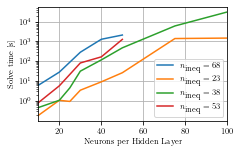

In [10]:
for horizon, values in runtime_by_hoizon.items():
    mask = np.argsort(values[0])
    mask = [i for i in mask if values[1][i]+1 == 4]
    plt.plot(values[0][mask], values[2][mask], label=r'$n_\textrm{ineq}=' + str(n_ineq_for_horizon(horizon)) + '$')

plt.legend()
plt.grid()
plt.yscale('log')
plt.xlim([10, 100])
plt.xlabel('Neurons per Hidden Layer')
plt.ylabel('Solve time [s]')
plt.savefig(f'figures/comp_times_ineq.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()

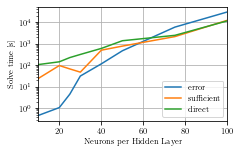

In [11]:
for horizon, values in runtime_by_hoizon.items():
    if horizon == 10:
        mask = np.argsort(values[0])
        mask = [i for i in mask if values[1][i]+1 == 4]
        plt.plot(values[0][mask], values[2][mask], label='error')
        plt.plot(values[0][mask], values[3][mask], label='sufficient')
        plt.plot(values[0][mask], values[4][mask], label='direct')

plt.legend(loc='lower right')
plt.grid()
plt.yscale('log')
plt.xlim([10, 100])
plt.xlabel('Neurons per Hidden Layer')
plt.ylabel('Solve time [s]')
plt.savefig(f'figures/comp_times_all_methods.pdf', bbox_inches='tight', pad_inches=0.01)
plt.show()